# 0.0 IMPORTS

In [276]:
import math
import numpy as np
import pandas as pd
import inflection
import datetime as dt

from tabulate import tabulate
from scipy import stats as ss
import seaborn as sns
from matplotlib import pyplot as plt

from IPython.core.display import HTML
from IPython.display import Image


## 0.1 Helper Functions

In [277]:
# calcula a medida de associação entre duas variáveis categóricas usando o coeficiente de Cramer's V
def cramer_v( x, y ):
    # cria uma tabela de contingência a partir das duas variáveis categóricas x e y, e transforma em uma matriz NumPy
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    # calcula o qui-quadrado para a tabela de contingência cm, e retorna o valor qui-quadrado.
    chi2 = ss.chi2_contingency( cm )[0]
    
    # calcula o valor corrigido de qui-quadrado, que leva em conta o tamanho da tabela de contingência.
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    # calcula o número de colunas corrigido.
    kcorr = k - (k-1)**2/(n-1)

    # calcula o número de linhas corrigido.
    rcorr = r - (r-1)**2/(n-1)

    # 'min(kcorr-1, rcorr-1)': calcula o menor valor entre o número de colunas corrigido menos 1 e o número de linhas corrigido menos 1.
    # 'np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))': calcula o coeficiente de Cramer's V como a raiz quadrada da razão entre o valor corrigido de qui-quadrado e o menor valor entre o número de colunas e o número de linhas corrigido menos 1.
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## 0.2 Loading Data

In [232]:

# Lê o arquivo todo de um vez
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)

df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge, 1º arquivo de referencia, 2º arquivo anexado a referencia, left, 
# coluna que é igual nos dois datasets e serve como chave para eu fazer o merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')



# 1.0 DESCRIÇÃO DOS DADOS

In [233]:

df1 = df_raw.copy()

## 1.1 Rename Columns

In [234]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map (snakecase, cols_old))

#rename
df1.columns = cols_new


## 1.2 Data Dimensions

In [235]:
#shampe --> printa linhas e colunas de um dataframe 
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [236]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [237]:
#mundando o tipo da coluna 'date'
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [238]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [239]:
# competition_distance 
# 
# tornar os NA em uma distancia maior que a maior distancia já encontrada no dataset
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)         

# competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval

#dicionario que associa o mês ao nome do mês
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Ouc', 11: 'Nov', 12: 'Dec',}
 
#preenche com NA para não ter que comparar usando ISNAN, mas poderia ter feito usando ISNAN
df1['promo_interval'].fillna(0, inplace=True)


#extrai o mês da coluna data e aplica o dicionario para fazer a tradução para o nome do mes
df1['month_map'] = df1['date'].dt.month.map(month_map)

# aplica a condicional para saber se o month_map está dentro daquele intervalo para saber se a loja está ou não em promoção
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [240]:

df1.isna().sum()

df1.sample(5).T


,920828,82721,158450,302933,376316
store,624,212,121,210,749
day_of_week,4,1,3,2,1
date,2013-03-28 00:00:00,2015-05-18 00:00:00,2015-03-11 00:00:00,2014-10-21 00:00:00,2014-08-04 00:00:00
sales,11781,5662,3519,3448,8071
customers,1070,474,436,347,839
open,1,1,1,1,1
promo,1,1,0,1,1
state_holiday,0,0,0,0,0
school_holiday,1,0,0,1,1
store_type,a,a,a,d,a


## 1.6 Change Types

In [241]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)




In [242]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics

In [243]:
num_attributes = df1.select_dtypes(include=['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'int32', 'datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [244]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

metrics


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='competition_distance', ylabel='Count'>

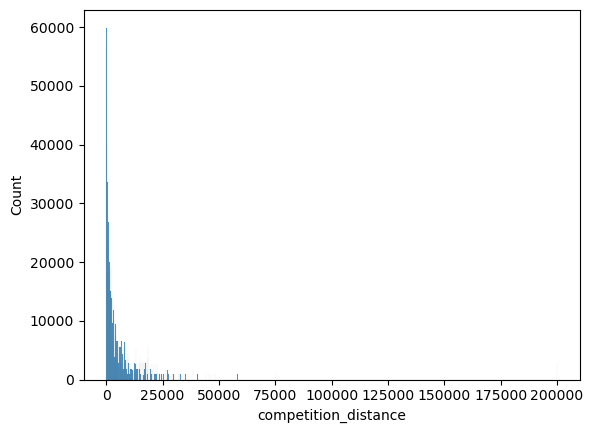

In [245]:
sns.histplot( df1['competition_distance'], kde=False )

#### 1.7.2 Categorical Attributes

In [246]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

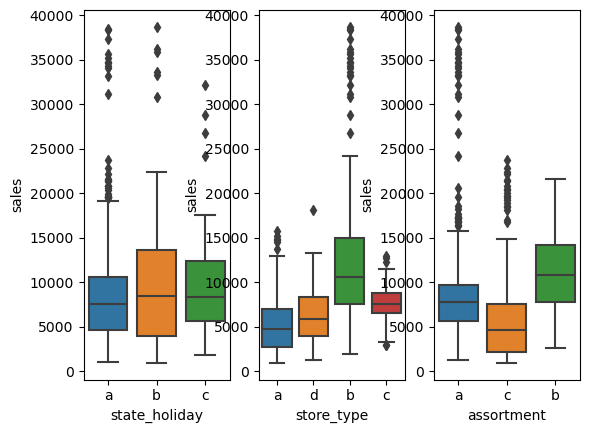

In [247]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

# 2.0 FEATURE ENGINEERING

In [248]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipoteses

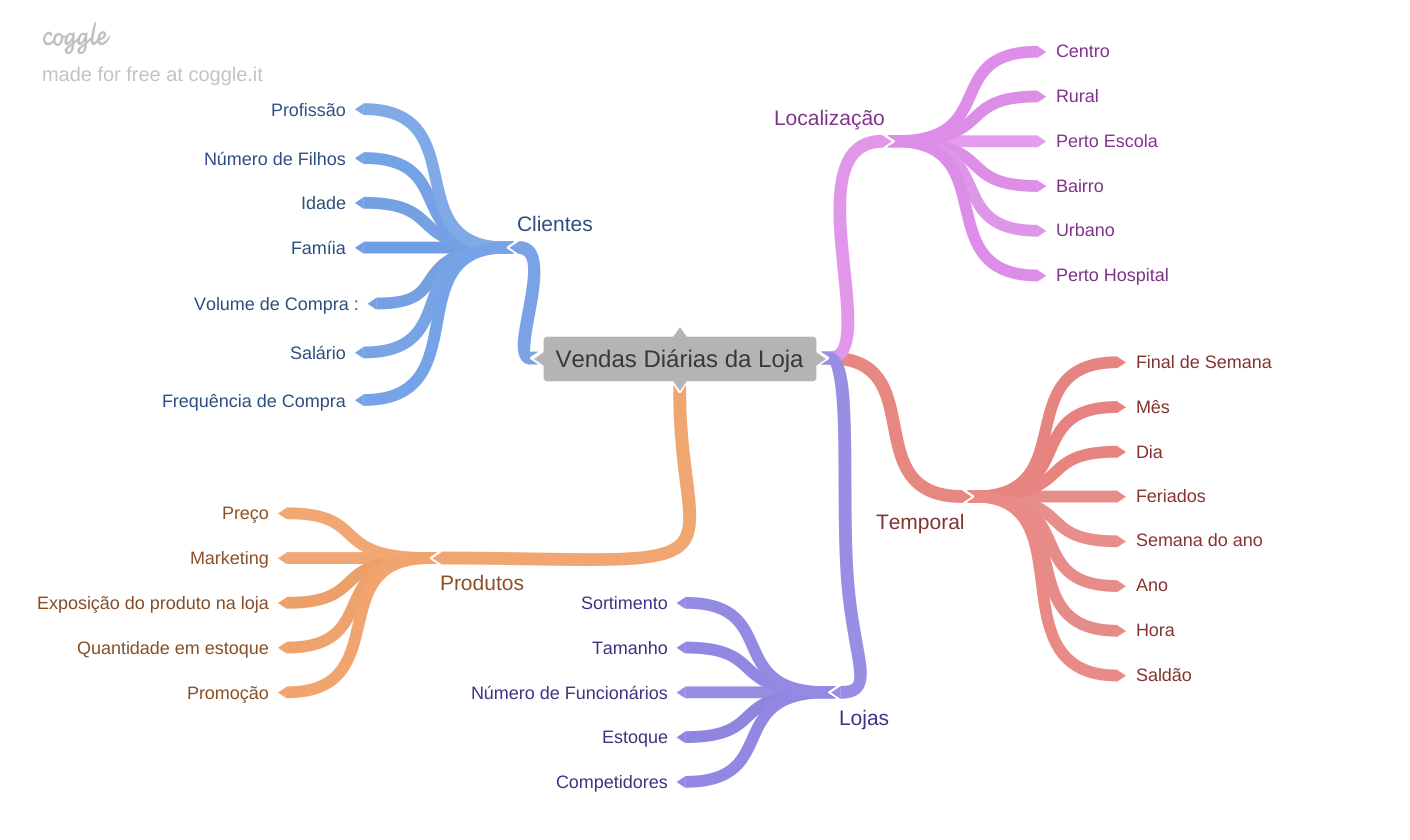

In [249]:
Image( 'img/Vendas_Dirias_da_Loja.png' )

## 2.2. Criacao das Hipoteses

#### 2.2.1. Hipoteses Loja

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

#### 2.2.2. Hipoteses Produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

#### 2.2.3. Hipoteses Tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [250]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: dt.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'] )/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: dt.datetime.strptime(x + '-1', '%Y-%W-%w') - dt.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


##### SOBRE O CÓDIGO

Esse código realiza transformações em um DataFrame chamado df2, com o objetivo de criar novas colunas que representam informações relevantes a partir de outras colunas já existentes.

As linhas de código abaixo das colunas year, month, day e week_of_year usam a função dt (datetime) para extrair essas informações a partir da coluna date, que deve ser uma coluna de data no formato datetime. A coluna week_of_year utiliza o método isocalendar() que retorna a semana do ano em que uma determinada data se encontra.

A linha de código year_week cria uma nova coluna year_week que representa o ano e semana correspondente de cada data no formato 'YYYY-WW'.

As linhas de código seguintes, competition_since e promo_since, criam novas colunas competition_since e promo_since a partir de outras colunas existentes, competition_open_since_year, competition_open_since_month, promo2_since_year e promo2_since_week. Essas colunas representam as datas em que as competições e promoções começaram, respectivamente. A função lambda é usada para criar uma nova coluna que calcula o tempo em meses ou semanas desde que a competição ou promoção começou até a data atual, dependendo da coluna.

A linha de código seguinte assortment transforma a coluna assortment em uma nova coluna assortment com os valores 'basic', 'extra' ou 'extended', dependendo do valor original da coluna.

A última linha de código, state_holiday, transforma a coluna state_holiday em uma nova coluna state_holiday com os valores 'public_holiday', 'easter_holiday', 'christmas' ou 'regular_day', dependendo do valor original da coluna.


# 3.0 FILTRAGEM DE VARIÁVEIS

In [251]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [252]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [253]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

##### SOBRE O CÓDIGO

A função drop() é usada para remover essas colunas do DataFrame df3. O argumento axis=1 indica que as colunas devem ser removidas (o valor padrão é axis=0, que indica que as linhas devem ser removidas).

As colunas que foram removidas são: customers, open, promo_interval e month_map.

# 4.0 ANALISE EXPLORATORIA DOS DADOS

In [254]:
df4 = df3.copy()

## 4.1 Analise Univariada

#### 4.1.1 Response Variable

<Axes: xlabel='sales', ylabel='Count'>

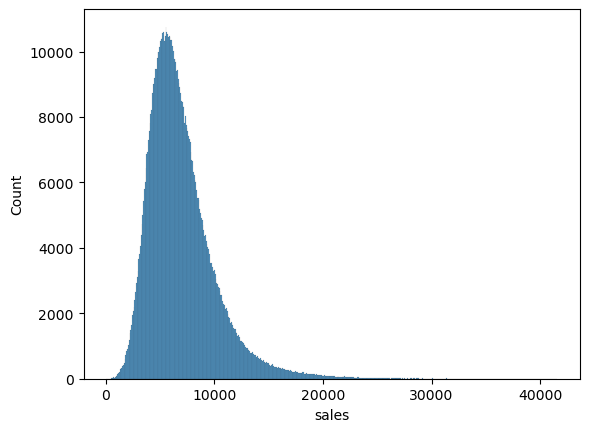

In [255]:
# plota um histograma dos dados da coluna "sales" do DataFrame df4 usando a 
# biblioteca Seaborn (sns). O parâmetro kde=False é usado para indicar que não
# será plotada uma estimativa de densidade kernel sobre o histograma (seu valor 
# padrão é True).

sns.histplot( df4['sales'], kde=False )

#### 4.1.2 Numerical Variable

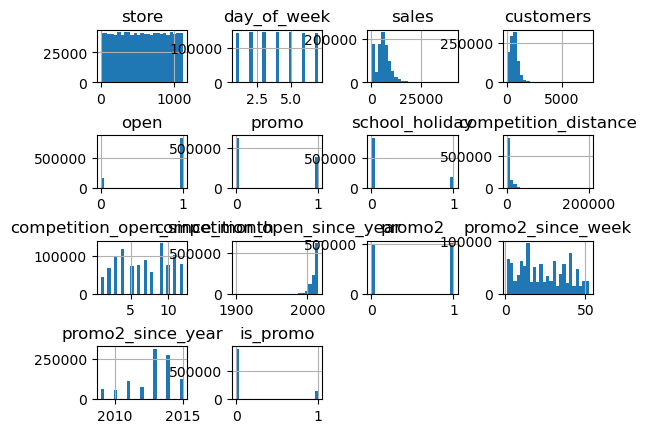

In [256]:
# num_attributes.hist(bins=25) plota o histograma das variáveis 
#numéricas contidas no DataFrame num_attributes. O parâmetro bins define o 
#número de intervalos de igual largura em que os valores serão agrupados para 
#gerar o histograma.

# O histograma é uma representação gráfica da distribuição de frequência dos 
# valores de uma variável numérica. Ele divide a faixa de valores da variável em 
# intervalos e conta quantas vezes um valor cai dentro de cada intervalo. A altura de 
# cada barra do histograma representa a frequência relativa dos valores dentro do intervalo 
# correspondente.

# Ao plotar o histograma, é possível visualizar a distribuição dos valores da variável, identificar 
# possíveis outliers, avaliar a simetria da distribuição, verificar se há evidência de múltiplos picos, 
# entre outras informações que podem ser úteis para a análise exploratória de dados e para a escolha do 
# modelo de Machine Learning mais adequado para o problema em questão.


num_attributes.hist(bins=25);
plt.subplots_adjust(hspace=1, wspace=0.5);

### 4.1.3 Categorical Variable

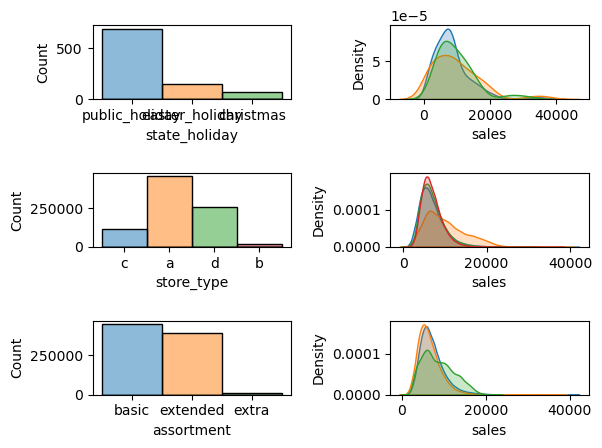

In [257]:
# state_holiday

#ubplot com 3 linhas, 2 colunas e selecionando o primeiro plot para plotar um gráfico
plt.subplot(3, 2, 1)

#cria um subconjunto do dataframe original 'a'ArithmeticError excluindo todas as linhas que correspondem a dias regulares de funcionamento
a = df4[df4['state_holiday'] != 'regular_day']

#O parâmetro 'x' especifica a coluna do DataFrame que será usada para criar o histograma. 
# O parâmetro 'discrete' é definido como True, o que significa que o histograma é tratado como uma variável categórica, 
# em vez de uma variável numérica contínua. Isso resulta em uma exibição de barras separadas para cada valor único da coluna 'state_holiday'.
#hue atribui uma cor diferente para cada categoria
sns.histplot(a, x='state_holiday', hue='state_holiday', legend=False, discrete=True)


#subplot em uma figura, onde três gráficos de densidade são plotados para as vendas (sales) do df4, separados por state_holiday: public_holiday, easter_holiday e christmas.
#O parâmetro fill=True é usado para preencher a área sob as curvas. 
plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)


# store_type
plt.subplot(3, 2, 3)
#sns.countplot(df4['store_type'])
sns.histplot(df4, x='store_type', hue='store_type', legend=False, discrete=True)


#as vendas de cada tipo de loja são filtradas utilizando df4[df4['store_type'] == ...]
#a função sns.kdeplot é utilizada para plotar o gráfico de densidade de probabilidade para cada tipo de loja, com a legenda indicando o tipo de loja correspondente. 
plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)


# assortment
plt.subplot(3, 2, 5)
sns.histplot(df4, x='assortment', hue='assortment', legend=False, discrete=True)

#está sendo criado um gráfico de densidade de vendas para cada tipo de assortimento 
# (extended, basic e extra) usando o método sns.kdeplot(). 
# Os gráficos estão sendo preenchidos (fill=True) e estão sendo adicionados labels para cada linha. 
# Esse subplot mostra como as vendas são distribuídas para cada tipo de assortimento.
plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)

plt.subplots_adjust(hspace=1, wspace=0.5);

## 4.2 Analise Bivariada

##### H1. Lojas com maior sortimentos deveriam vender mais.

FALSA Lojas com MAIOR SORTIMENTO vendem MENOS

<Axes: xlabel='year_week'>

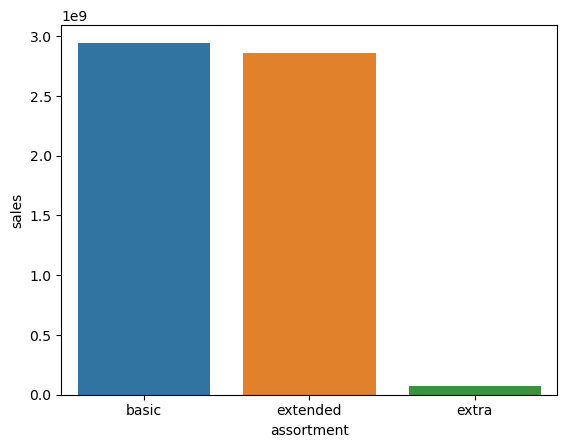

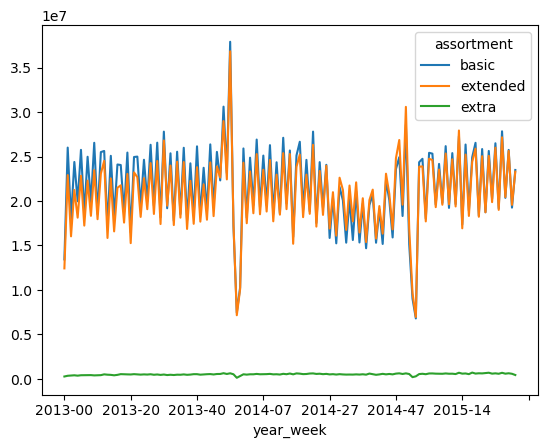

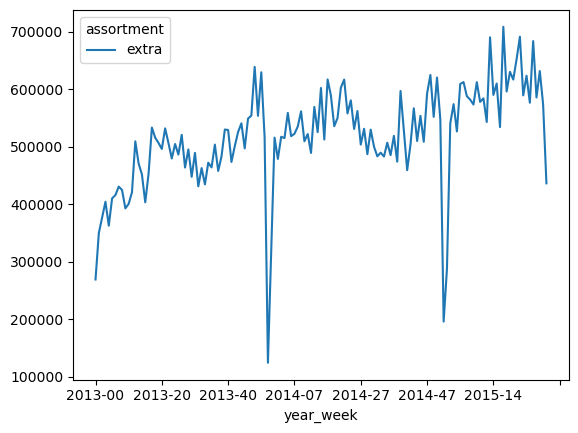

In [258]:
# aux1 contém a soma das vendas (sales) agrupadas pela categoria de surtimento (assortment).
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

# aux2 contém a soma de sales agrupadas por year_week e assortment.
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()

# criado um gráfico de linhas (usando o método pivot) de aux2, onde o índice é a semana do ano, as colunas são as 
# assortment e os valores são as sales
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()


aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

##### H2. Lojas com competidores mais próximos deveriam vender menos.

FALSA Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

C:\Users\raquel\AppData\Local\Temp\ipykernel_18508\1101030001.py:23: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap(aux1.corr(method='pearson'), annot=True);


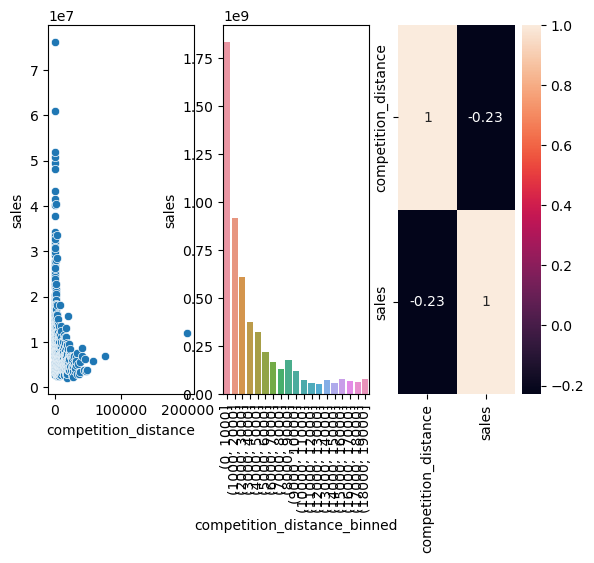

In [259]:
#agrupa as colunas "competition_distance" e "sales" pelo valor de "competition_distance", calculando a soma das vendas para cada valor de distância de competição
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()


#gerado um gráfico de dispersão (scatterplot) com "competition_distance" no eixo x e "sales" no eixo y, usando os dados do DataFrame "aux1"
plt.subplot(1, 3, 1)
sns.scatterplot(x ='competition_distance', y='sales', data=aux1);

#gerado um histograma de barras (barplot) com "competition_distance_binned" no eixo x (os valores de distância agrupados em bins) e a soma das vendas no eixo y, usando os dados do DataFrame "aux2"
plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))

#criando uma nova coluna no dataframe aux1 chamada competition_distance_binned, onde os valores da coluna competition_distance são agrupados em faixas (bins) de tamanho 1000, usando a função pd.cut
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

#dataframe é agrupado por competition_distance_binned e sales e a soma das vendas é calculada para cada grupo.
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

#gerado um mapa de calor (heatmap) com a correlação entre as colunas de "aux1" usando o método de correlação de Pearson.
plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);



##### H3. Lojas com competidores há mais tempo deveriam vendem mais.

FALSA Lojas com COMPETIDORES HÁ MAIS TEMPO vendem MENOS.

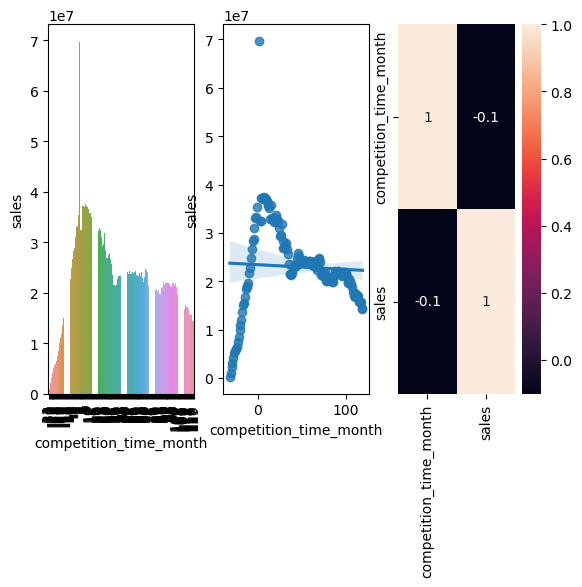

In [260]:
plt.subplot(1, 3, 1)

# agrupa as colunas 'competition_time_month' e 'sales' pelo valor de 'competition_time_month', somando as vendas e resetando o índice.
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

#filtra apenas as linhas em que 'competition_time_month' é menor do que 120 e diferente de 0, e atribuindo o resultado à variável 'aux2'
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

#cria um gráfico de barras usando 'competition_time_month' como eixo x, 'sales' como eixo y e os dados de 'aux2
sns.barplot(x='competition_time_month', y='sales', data=aux2);

#rotaciona os ticks do eixo x em 90 graus
plt.xticks(rotation=90);


#cria um gráfico de regressão linear usando 'competition_time_month' como eixo x, 'sales' como eixo y e os dados de 'aux2'.
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);


plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr( method='pearson'), annot=True);


##### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
FALSA Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao

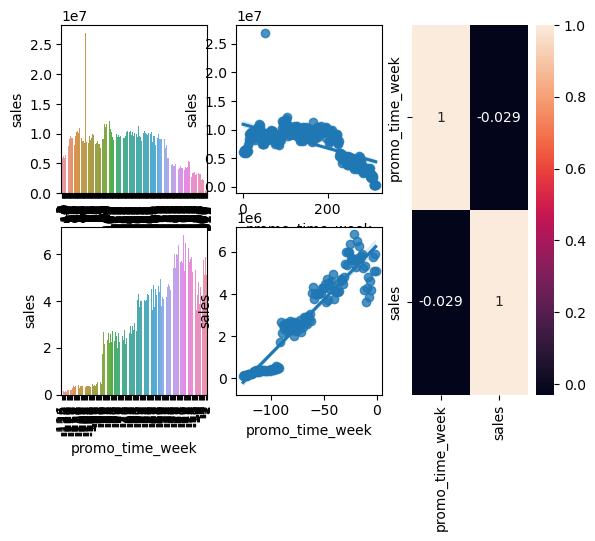

In [261]:
# Calcula a soma das vendas agrupadas pelo tempo de promoção
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

# Define a grade de subplots com 2 linhas e 3 colunas
grid = plt.GridSpec(2, 3)

# Cria o subplot na posição [0,0] da grade
plt.subplot(grid[0,0])
# Seleciona apenas as linhas com promoção estendida (tempo de promoção maior que zero)
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
# Cria um gráfico de barras do tempo de promoção estendida em relação às vendas
sns.barplot(x='promo_time_week', y='sales', data=aux2);
# Rotaciona os rótulos do eixo x em 90 graus
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
# Cria um gráfico de regressão linear do tempo de promoção estendida em relação às vendas
sns.regplot( x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
# Seleciona apenas as linhas com promoção regular (tempo de promoção menor que zero)
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
# Cria um gráfico de regressão linear do tempo de promoção regular em relação às vendas
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
# Cria um mapa de calor da correlação entre as colunas de aux1 usando o método de correlação de Pearson
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### H5. Lojas com mais dias de promoção deveriam vender mais.

##### H6. Lojas com mais promoções consecutivas deveriam vender mais.
FALSA Lojas com mais promocoes consecutivas vendem menos

In [262]:
# Agrupa as colunas de promoção e vendas pelo valor das promoções
# e soma as vendas para cada combinação de valores de promoção
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


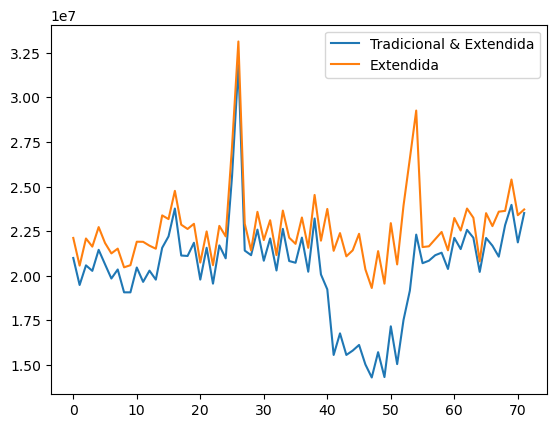

In [263]:
# Seleciona apenas as linhas com promoção tradicional (promo = 1) e promoção estendida (promo2 = 1)
# Agrupa as vendas pelo número da semana do ano e soma as vendas para cada semana
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

# Seleciona apenas as linhas com promoção tradicional (promo = 1) e sem promoção estendida (promo2 = 0)
# Agrupa as vendas pelo número da semana do ano e soma as vendas para cada semana
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

##### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
FALSA Lojas abertas durante o feriado do Natal vendem menos

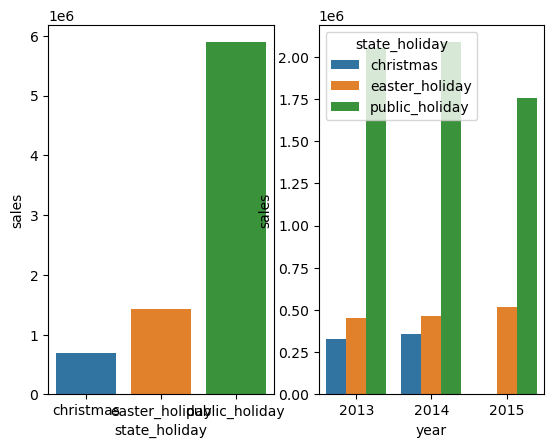

In [264]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

##### H8. Lojas deveriam vender mais ao longo dos anos.
FALSA Lojas vendem menos ao longo dos anos

<Axes: >

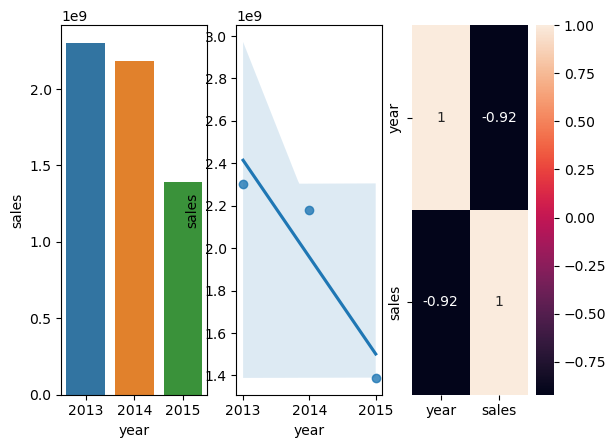

In [265]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


##### H9. Lojas deveriam vender mais no segundo semestre do ano.
FALSA Lojas vendem menos no segundo semestre do ano

<Axes: xlabel='month', ylabel='sales'>

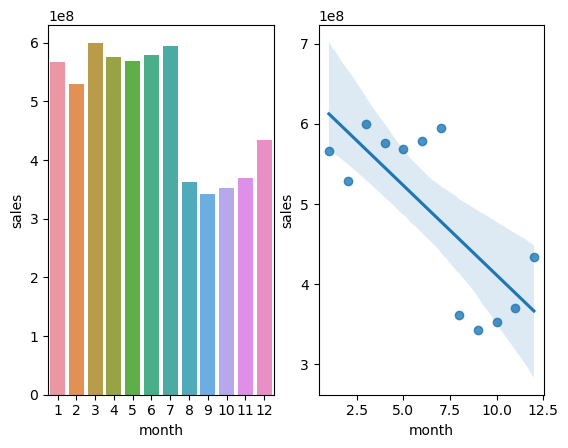

In [266]:
aux1 = df4[['sales', 'month']].groupby('month').sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 2, 2)
sns.regplot(x='month', y='sales', data=aux1)



# aux = df4[df4['month'] > 6]
# aux2 = aux[['month', 'sales']].groupby('month').sum().reset_index()
# plt.subplot(1, 2, 2)
# sns.barplot(x='month', y='sales', data=aux2)


##### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
VERDADEIRA Lojas vendem mais depois do dia 10 de cada mes

<Axes: xlabel='before_after_middle', ylabel='sales'>

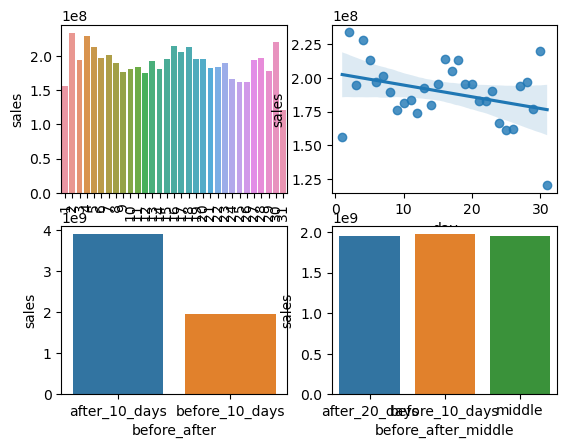

In [267]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1);
sns.barplot(x='day', y='sales', data=aux1)
plt.xticks(rotation=90);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
plt.subplot(2, 2, 3)
sns.barplot(x='before_after', y='sales', data=aux2)


aux1['before_after_middle'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'middle' if x <= 20 else 'after_20_days')
aux2 =aux1[['before_after_middle', 'sales']].groupby('before_after_middle').sum().reset_index()
plt.subplot(2, 2, 4)
sns.barplot(x='before_after_middle', y='sales', data=aux2)

##### H11. Lojas deveriam vender menos aos finais de semana.
VERDADEIRA Lojas vendem menos nos final de semana

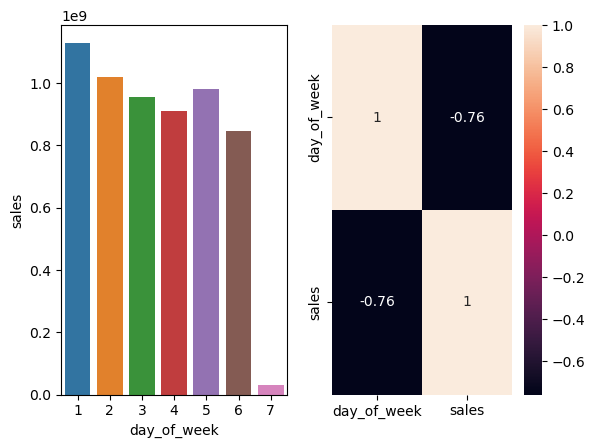

In [268]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)


plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr( method='pearson'), annot=True);


##### H12. Lojas deveriam vender menos durante os feriados escolares.
VERDADEIRA Lojas vendem menos durante os feriados escolares, exceto o mes de Agosto.

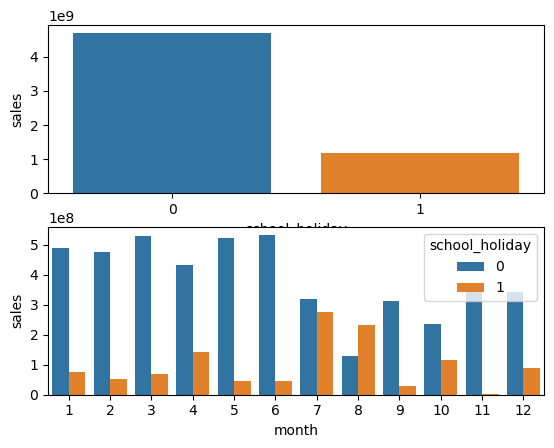

In [269]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

#### 4.2.1 Resumo das Hipoteses

In [270]:

tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Analise Multivariada

#### 4.3.1 Numerical Attributes

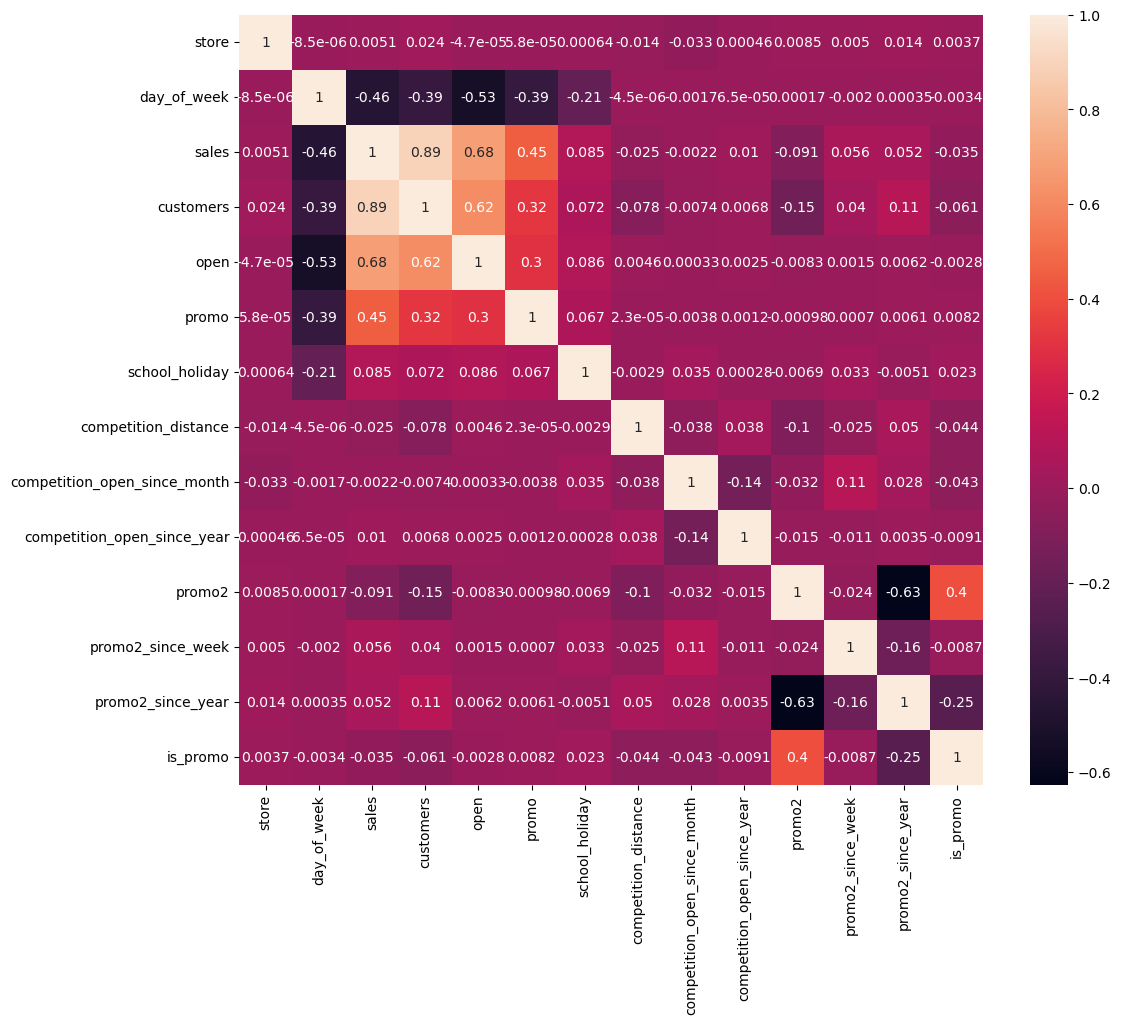

In [271]:
fig, ax = plt.subplots(figsize=(12, 10))

correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

#### 4.3.2 Categorical Attributes

<Axes: >

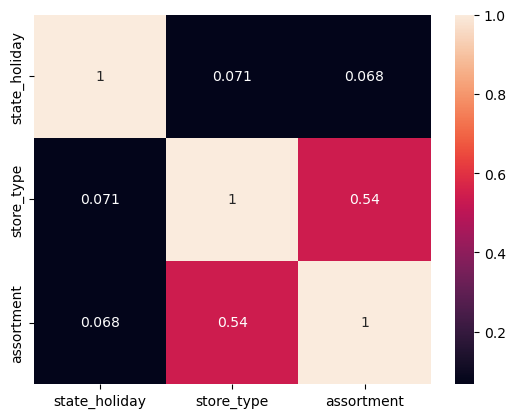

In [278]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                    'store_type': [a4, a5, a6],
                    'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )